# Getting started with Sentinel 2 data

**Background** Sentinel 2 data is available to access within the a development instance of DEA. In order to access this development environment, you need to set up a configuration file, and point to this when you load `Datacube`. This code assumes that you have already completed this step.

**What does this notebook do?** This notebook steps you through how to load in and plot up data from Sentinel 2. It explores the data that are available from the Sentinel 2 satellite, and briefly describes the Sentinel satellite bands. It then loads in the `s2a_ard_granule` product and plots it up in true and false colour. It uses the provided pixel quality data to filters the example scene based on `cloud` and `cloud shadow`-free pixels. 

**Date**: March 2018.

**Author**: Claire Krause

In [1]:
%matplotlib inline
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import numpy as np

import sys
import os
# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/algorithms'))
import DEAPlotting
import DEADataHandling

# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/156/cek156/Sentinel2_datacube.conf')

## See what Sentinel 2 products are currently available

In [2]:
products = s2aws.list_products()
display_columns = ['name', 'description', 'instrument', 'platform', 'product_type', 'crs', 'resolution']
sentinel_products = products[products['instrument'] == 'MSI'][display_columns]
sentinel_products

name                                        description  \
id                                                                           
44      s2a_ard_granule  Sentinel-2A MSI ARD - NBAR NBART and Pixel Qua...   
41  s2a_level1c_granule  Sentinel-2A Level1C - Ortho Rectified Top of A...   
43  s2a_sen2cor_granule  Sentinel-2 Level 2 - Sen2Cor Bottom of Atmosph...   
45      s2b_ard_granule  Sentinel-2B MSI ARD - NBAR NBART and Pixel Qua...   
42  s2b_level1c_granule  Sentinel-2B Level1C - Ortho Rectified Top of A...   

   instrument     platform product_type  crs resolution  
id                                                       
44        MSI  Sentinel-2A     S2MSIARD  NaN        NaN  
41        MSI  Sentinel-2A      S2MSI1C  NaN        NaN  
43        MSI  SENTINEL_2A     S2MSI2Ap  NaN        NaN  
45        MSI  Sentinel-2B     S2MSIARD  NaN        NaN  
42        MSI  Sentinel-2B      S2MSI1C  NaN        NaN

There are two spectral Sentinel satellites currently in DEA; **Sentinel-2A** and **Sentinel-2B**. Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.

Both of the Sentinel 2 satellites carries an innovative wide swath high-resolution multispectral imager with 13 spectral bands. The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery. Together they cover all Earth's land surfaces, large islands, inland and coastal waters every five days at the equator.

For more information on the Sentinel 2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2). 

## Now we want to actually load and look at some data

We will focus on data from the Sentinel-2a platform for this demonstration, as there is more data available than 2b. To explore the spectral datasets from Sentinel-2a, we will use the `s2a_ard_granule` product. Sometimes multiple scenes are acquired by the satellite on the same day. We want to group these together, and will use `group_by='solar_day'` to do this.

To load in the Sentinel data, we have a number of options we can use in building our data extraction query:

* `lat`/`lon` - specify a bounding box for the extraction. Note that a polygon can be used instead. See [here](https://datacube-core.readthedocs.io/en/stable/dev/generate/datacube.api.query.Query.html#datacube.api.query.Query) for more details
* `output_crs` - the output coordinate reference system to project the data into. The CRS you request will impact on the format for the `resolution` query. Two handy CRSs are 'EPSG:3577', which is the Australian Albers projected coordinate system, and 'EPSG:4325', which is WGS84 a global geographic coordinate system.
* `resolution` - the requested output resolution for the data. If you have selected a geographic coordinate system for the `output_crs`, this will be in degrees. If you have selected a projected coordinate system, this will be in metres. 
* `time` - the time range for the query.

In [3]:
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-01-01', '2017-02-15')
        }

Canberra = s2aws.load(product='s2a_ard_granule', group_by='solar_day', **query)

### See what came back from the extraction

In [4]:
Canberra

<xarray.Dataset>
Dimensions:        (time: 4, x: 1229, y: 1248)
Coordinates:
  * time           (time) datetime64[ns] 2017-01-05T00:02:12.026000 ...
  * y              (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x              (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    pixel_quality  (time, y, x) uint8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 ...
    contiguity     (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    aerosol        (time, y, x) int16 886 886 886 886 886 931 931 931 931 ...
    blue           (time, y, x) int16 777 703 714 732 814 782 752 773 690 ...
    green          (time, y, x) int16 904 839 843 865 910 877 837 816 739 ...
    red            (time, y, x) int16 987 843 858 828 963 907 822 892 795 ...
    rededge1       (time, y, x) int16 1291 1303 1303 1282 1282 1221 1221 ...
    rededge2       (time, y, x) int16 1975 1931 1931 1945 1945 1887 1887 ...
    rededge3       (time, y, x) int16 2336 2346 2346 23

## About Sentinel 2 bands
Sentinel 2 satellites have 13 spectral channels:

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `aerosol` | 1 | 443 | 60 | 20 |
| Blue | `blue` | 2 | 490 | 10 | 65 |
| Green | `green` | 3 | 560 | 10 | 35 |
| Red | `red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `rededge1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `rededge2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `rededge3` | 7 | 783 | 20 | 20 |
| NIR | `nir` | 8 | 842 | 10 | 115 |
| Narrow NIR | `rededge4` | 8A | 865 | 20 | 20 |
| Water vapour | N/A | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `swir1` | 11 | 1610 | 20 | 90 |
| SWIR | `swir2` | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths

![Sentinel 2 bands](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

### Data corrections

There are two corrections applied to the Sentinel data:

1. **NBAR (e.g. `green`)**  
NBAR stands for Nadir-corrected BRDF Adjusted Reflectance, where BRDF stands for Bidirectional reflectance distribution function The approach involves atmospheric correction to compute surface-leaving radiance, and bi-directional reflectance modelling to remove the effects of topography and angular variation in reflectance.

2. **T_NBAR (e.g. `t_green`)**  
Surface reflectance T_NBAR includes the terrain illumination reflectance correction and has the same features of NBAR, along with some additional features.

Note that the `t_nbar` data insert a missing value (`-9999`) into the dataset to denote a terrain shadow. This should be converted to a `NaN` value before using this data to avoid treating it as a valid value.


For more information on these corrections, see the explanation of the [Landsat archive data](http://geoscienceaustralia.github.io/digitalearthau/data/data.html#). 

## Plot this scene up as true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

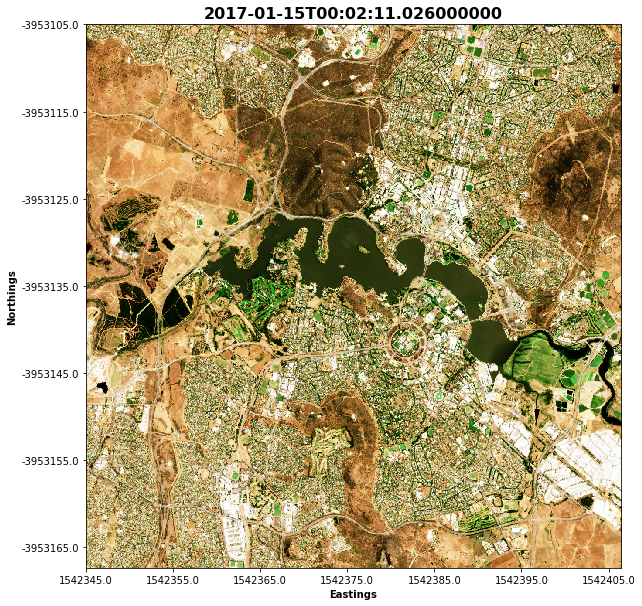

In [5]:
DEAPlotting.three_band_image(Canberra, bands = ['red', 'green', 'blue'], time = 1)

## Plot this scene up as false colour image

This plot uses the SWIR, NIR and green bands to accentuate the presence of water in the landscape.

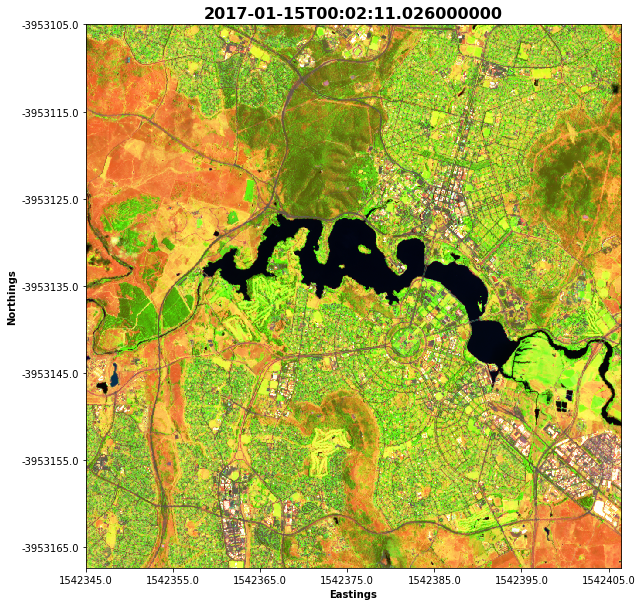

In [6]:
DEAPlotting.three_band_image(Canberra, bands = ['swir1','nir1','green'], time = 1)

## Compare some scenes side-by-side

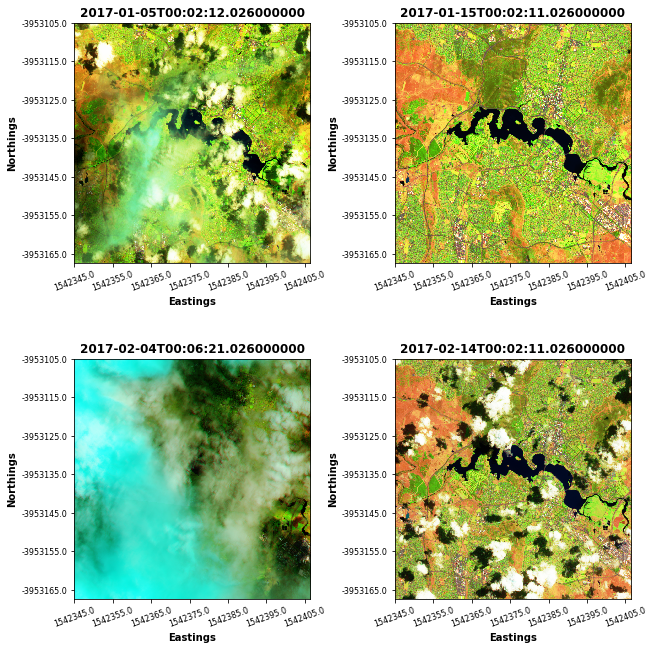

In [7]:
DEAPlotting.three_band_image_subplots(Canberra, bands = ['swir1','nir1','green'], 
                                      num_cols = 2, figsize = [10, 10], wspace = 0.35)

## Filter scenes using pixel quality

A pixel quality dataset is provided alongside the spectral data, which can be used to filter out noisy pixels. The key things we want to filter are clouds and shadows. 

The pixel quality field contains values from 0 to 5. 

| Value | Description |
|-------|-------------|
| 0 | Null |
| 1 | Valid |
| 2 | Cloud |
| 3 | Cloud shadow |
| 4 | Snow |
| 5 | Water |

In the Sentinel data, `clear` pixels are denoted as `1` in the pixel quality mask. We can use this to filter a cloudy image. 

### Here is the cloudy image we would like to mask

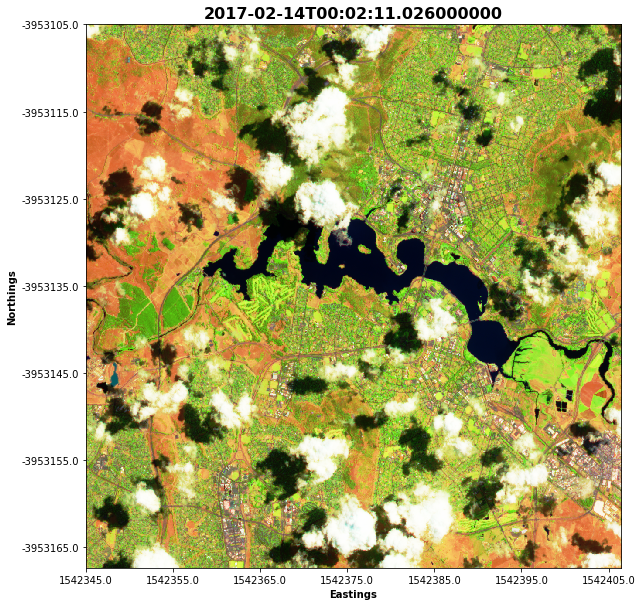

In [8]:
DEAPlotting.three_band_image(Canberra, bands = ['swir1','nir1','green'], time = 3)

### Plot up the pixel quality information for the same scene

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


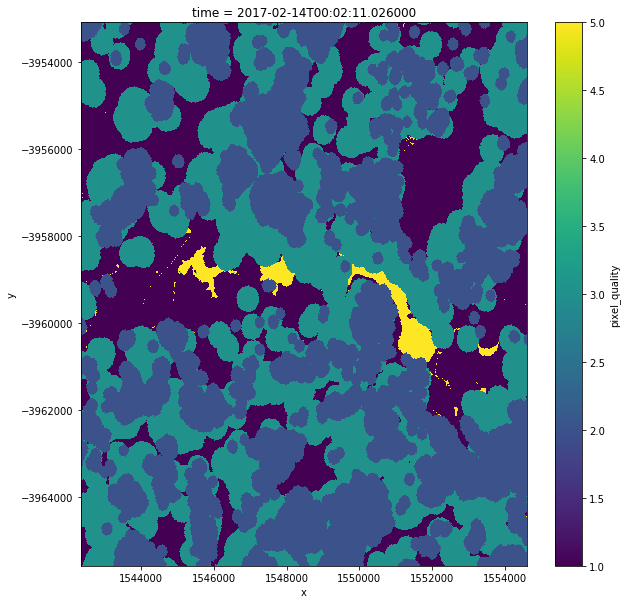

In [9]:
Canberra.isel(time = 3).pixel_quality.plot(figsize = [10, 10])

### Now use the pixel quality information to create a mask, and apply it to the spectral data

We want to filter out cloud and cloud shadow, so we will use the `pixelquality` values `2` and `3` for our filter.

In [10]:
clear_pixels = np.logical_and(Canberra.pixel_quality != 2, Canberra.pixel_quality != 3)
Clear_Canberra = Canberra.where(clear_pixels)

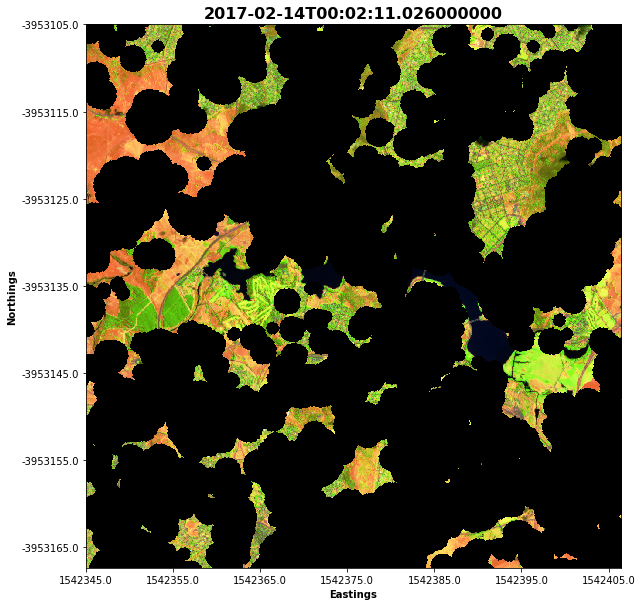

In [11]:
DEAPlotting.three_band_image(Clear_Canberra, bands = ['swir1','nir1','green'], time = 3)